# <div style="text-align: left; background-color:#e9c46a; font-family:Comic Sans MS ; color:#1A4870; padding: 12px; line-height:1.5; border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 70px;border-style: solid;border-color: dark green; font-weight: bold;"> House Prices Predictions </div>

<br>    
<p style="text-align: center;">
<img src="Images\house.avif" style='width: 900px; height: 500px;'>
</p>

<a id="top"></a>

# <p style="text-align: left; background-color:#e9c46a; font-family:Comic Sans MS ; color:#1A4870; padding: 12px; line-height:1.5; border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 50px;border-style: solid;border-color: dark green; font-weight: bold;">Table Of Contents</p>

* [Importing Libraries](#1)
* [Load The Data](#2)
* [Exploratory Data Analysis](#3)
* [Data Preprocessing](#4)
* [Modeling And HyperParameters Tuning](#5)
* [Evaluation On Test Data](#6)
* [Submission](#7)

In [3]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import (Pipeline, FeatureUnion)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.model_selection import (train_test_split, GridSearchCV)
# from sklearn_features.transformers import DataFrameSelector
from sklearn.metrics import (mean_squared_error, r2_score)
from sklearn.linear_model import (LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet)
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]


In [7]:
# Loading the Data
df = pd.read_csv(r"Data\train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# Exploratory Data Analysis
print(f"Number of rows in the dataset: {df.shape[0]}")
print(f"Number of columns in the dataset: {df.shape[1]}")

Number of rows in the dataset: 1460
Number of columns in the dataset: 81


In [11]:
# some information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [13]:
# Missing Values Ratio
missingRatio = df.isnull().sum() / df.shape[0]
missingRatio[missingRatio > 0.10]

LotFrontage    0.177397
Alley          0.937671
MasVnrType     0.597260
FireplaceQu    0.472603
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

**Observation:** 
- `Alley`, `PoolQC` and `MiscFeature` columns have `missing ratio > 90%` 

- `MasVnrType`, `Fence` columns have `90% > missing ratio > 50%`

- `LotFrontage`, `FireplaceQu` columns have `50%>= missing ratio > 10%`

In [15]:
# drop columns with nulls > 10%
df = df.drop(columns=missingRatio[missingRatio > 0.10].index)
# drop id column
df = df.drop(columns='Id')

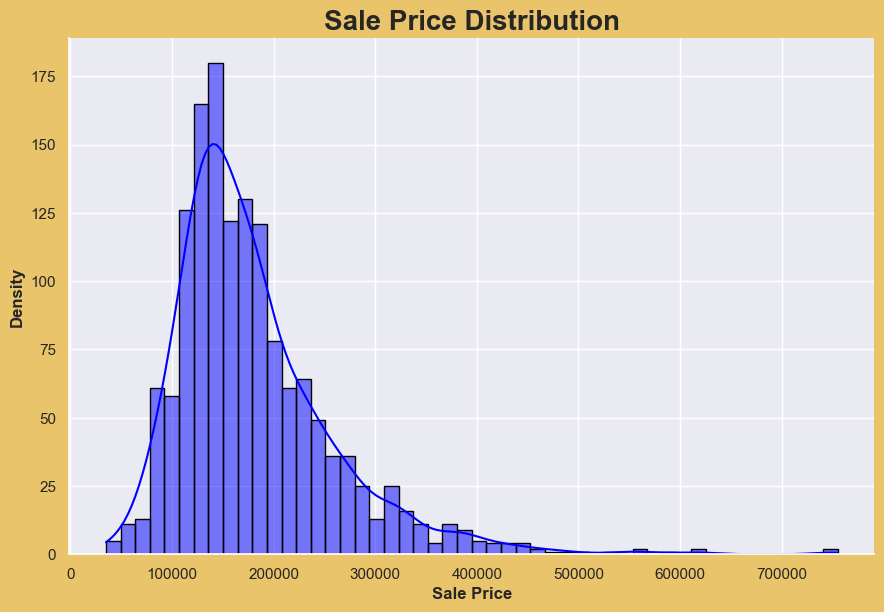

In [17]:
# Target Variable `Sale Price` Distribution
sns.set(style='darkgrid', rc={"figure.facecolor":"#e9c46a"})
sns.displot(df['SalePrice'], kde=True, height=6, aspect=1.5, color='blue', edgecolor='black', bins=50);
plt.xlabel("Sale Price", fontweight='bold')
plt.ylabel("Density", fontweight='bold')
plt.title("Sale Price Distribution",
        fontsize=20, 
        fontweight='bold');

In [19]:
# Numerical Features
numFeatures = df.select_dtypes(include=['float64', 'int64'])
numFeatures.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,8450,7,5,2003,2003,196.0,706,0,150,...,0,61,0,0,0,0,0,2,2008,208500
1,20,9600,6,8,1976,1976,0.0,978,0,284,...,298,0,0,0,0,0,0,5,2007,181500
2,60,11250,7,5,2001,2002,162.0,486,0,434,...,0,42,0,0,0,0,0,9,2008,223500
3,70,9550,7,5,1915,1970,0.0,216,0,540,...,0,35,272,0,0,0,0,2,2006,140000
4,60,14260,8,5,2000,2000,350.0,655,0,490,...,192,84,0,0,0,0,0,12,2008,250000


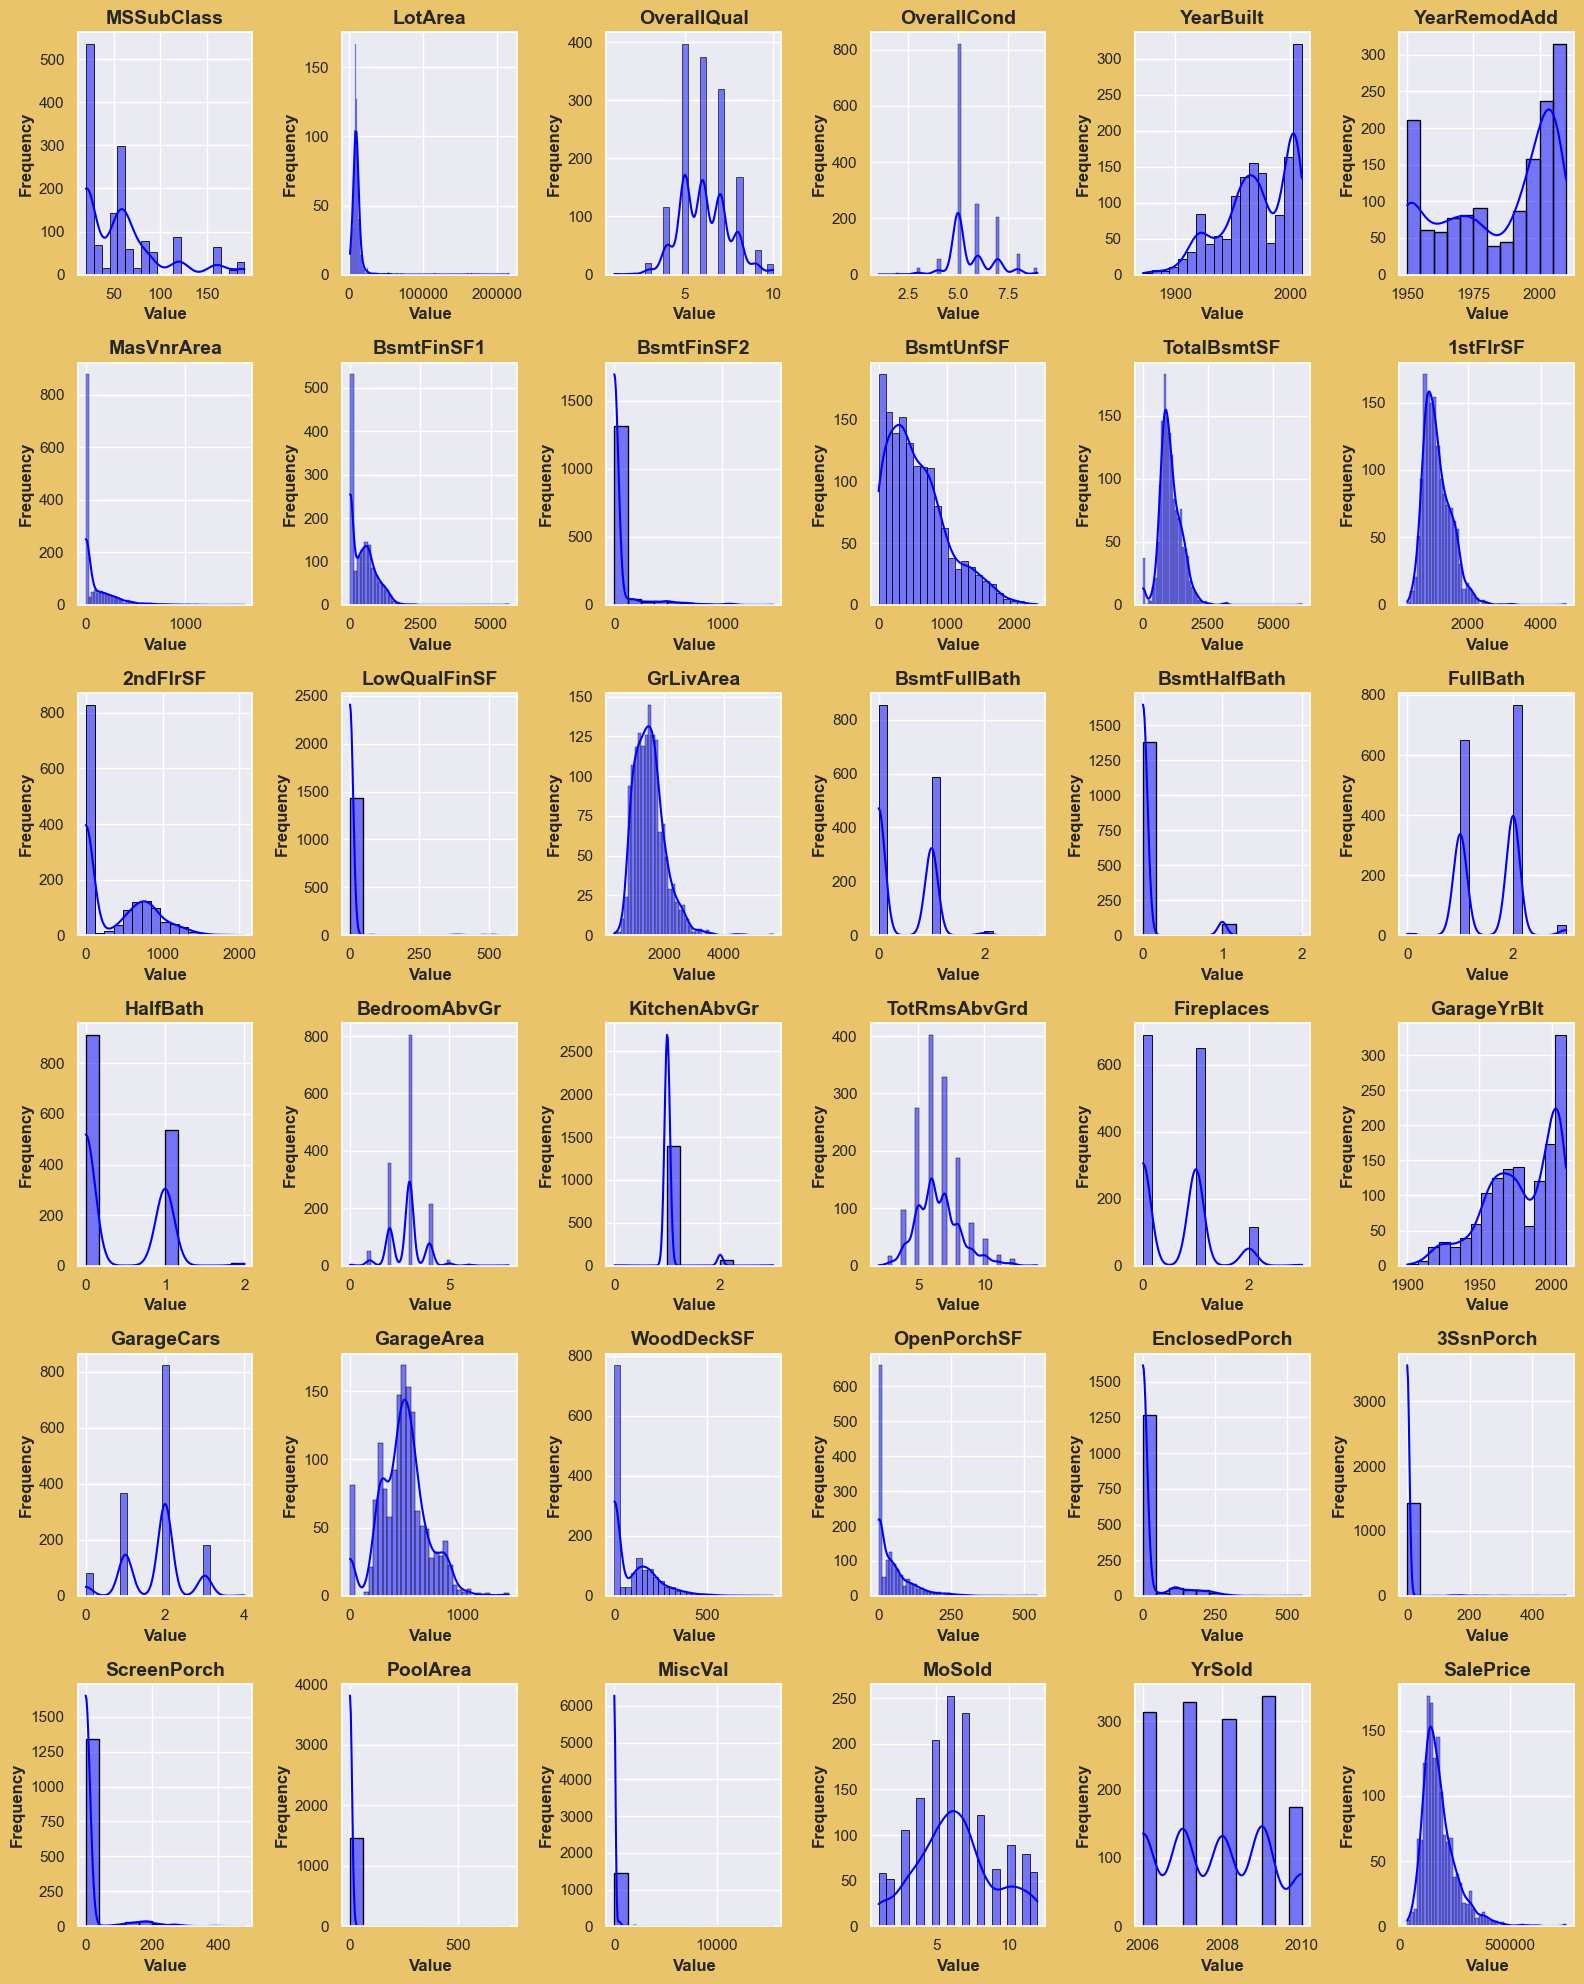

In [21]:
# Distribution Of Numerical Features
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(16, 20))
axes = axes.flatten()

for index, col in enumerate(numFeatures.columns):
    sns.histplot(numFeatures[col], kde=True, ax=axes[index], color='blue', edgecolor='black')
    axes[index].set_title(col, fontweight='bold', fontsize=14)
    axes[index].set_xlabel('Value', fontweight='bold')
    axes[index].set_ylabel('Frequency', fontweight='bold')

plt.tight_layout()
plt.show()

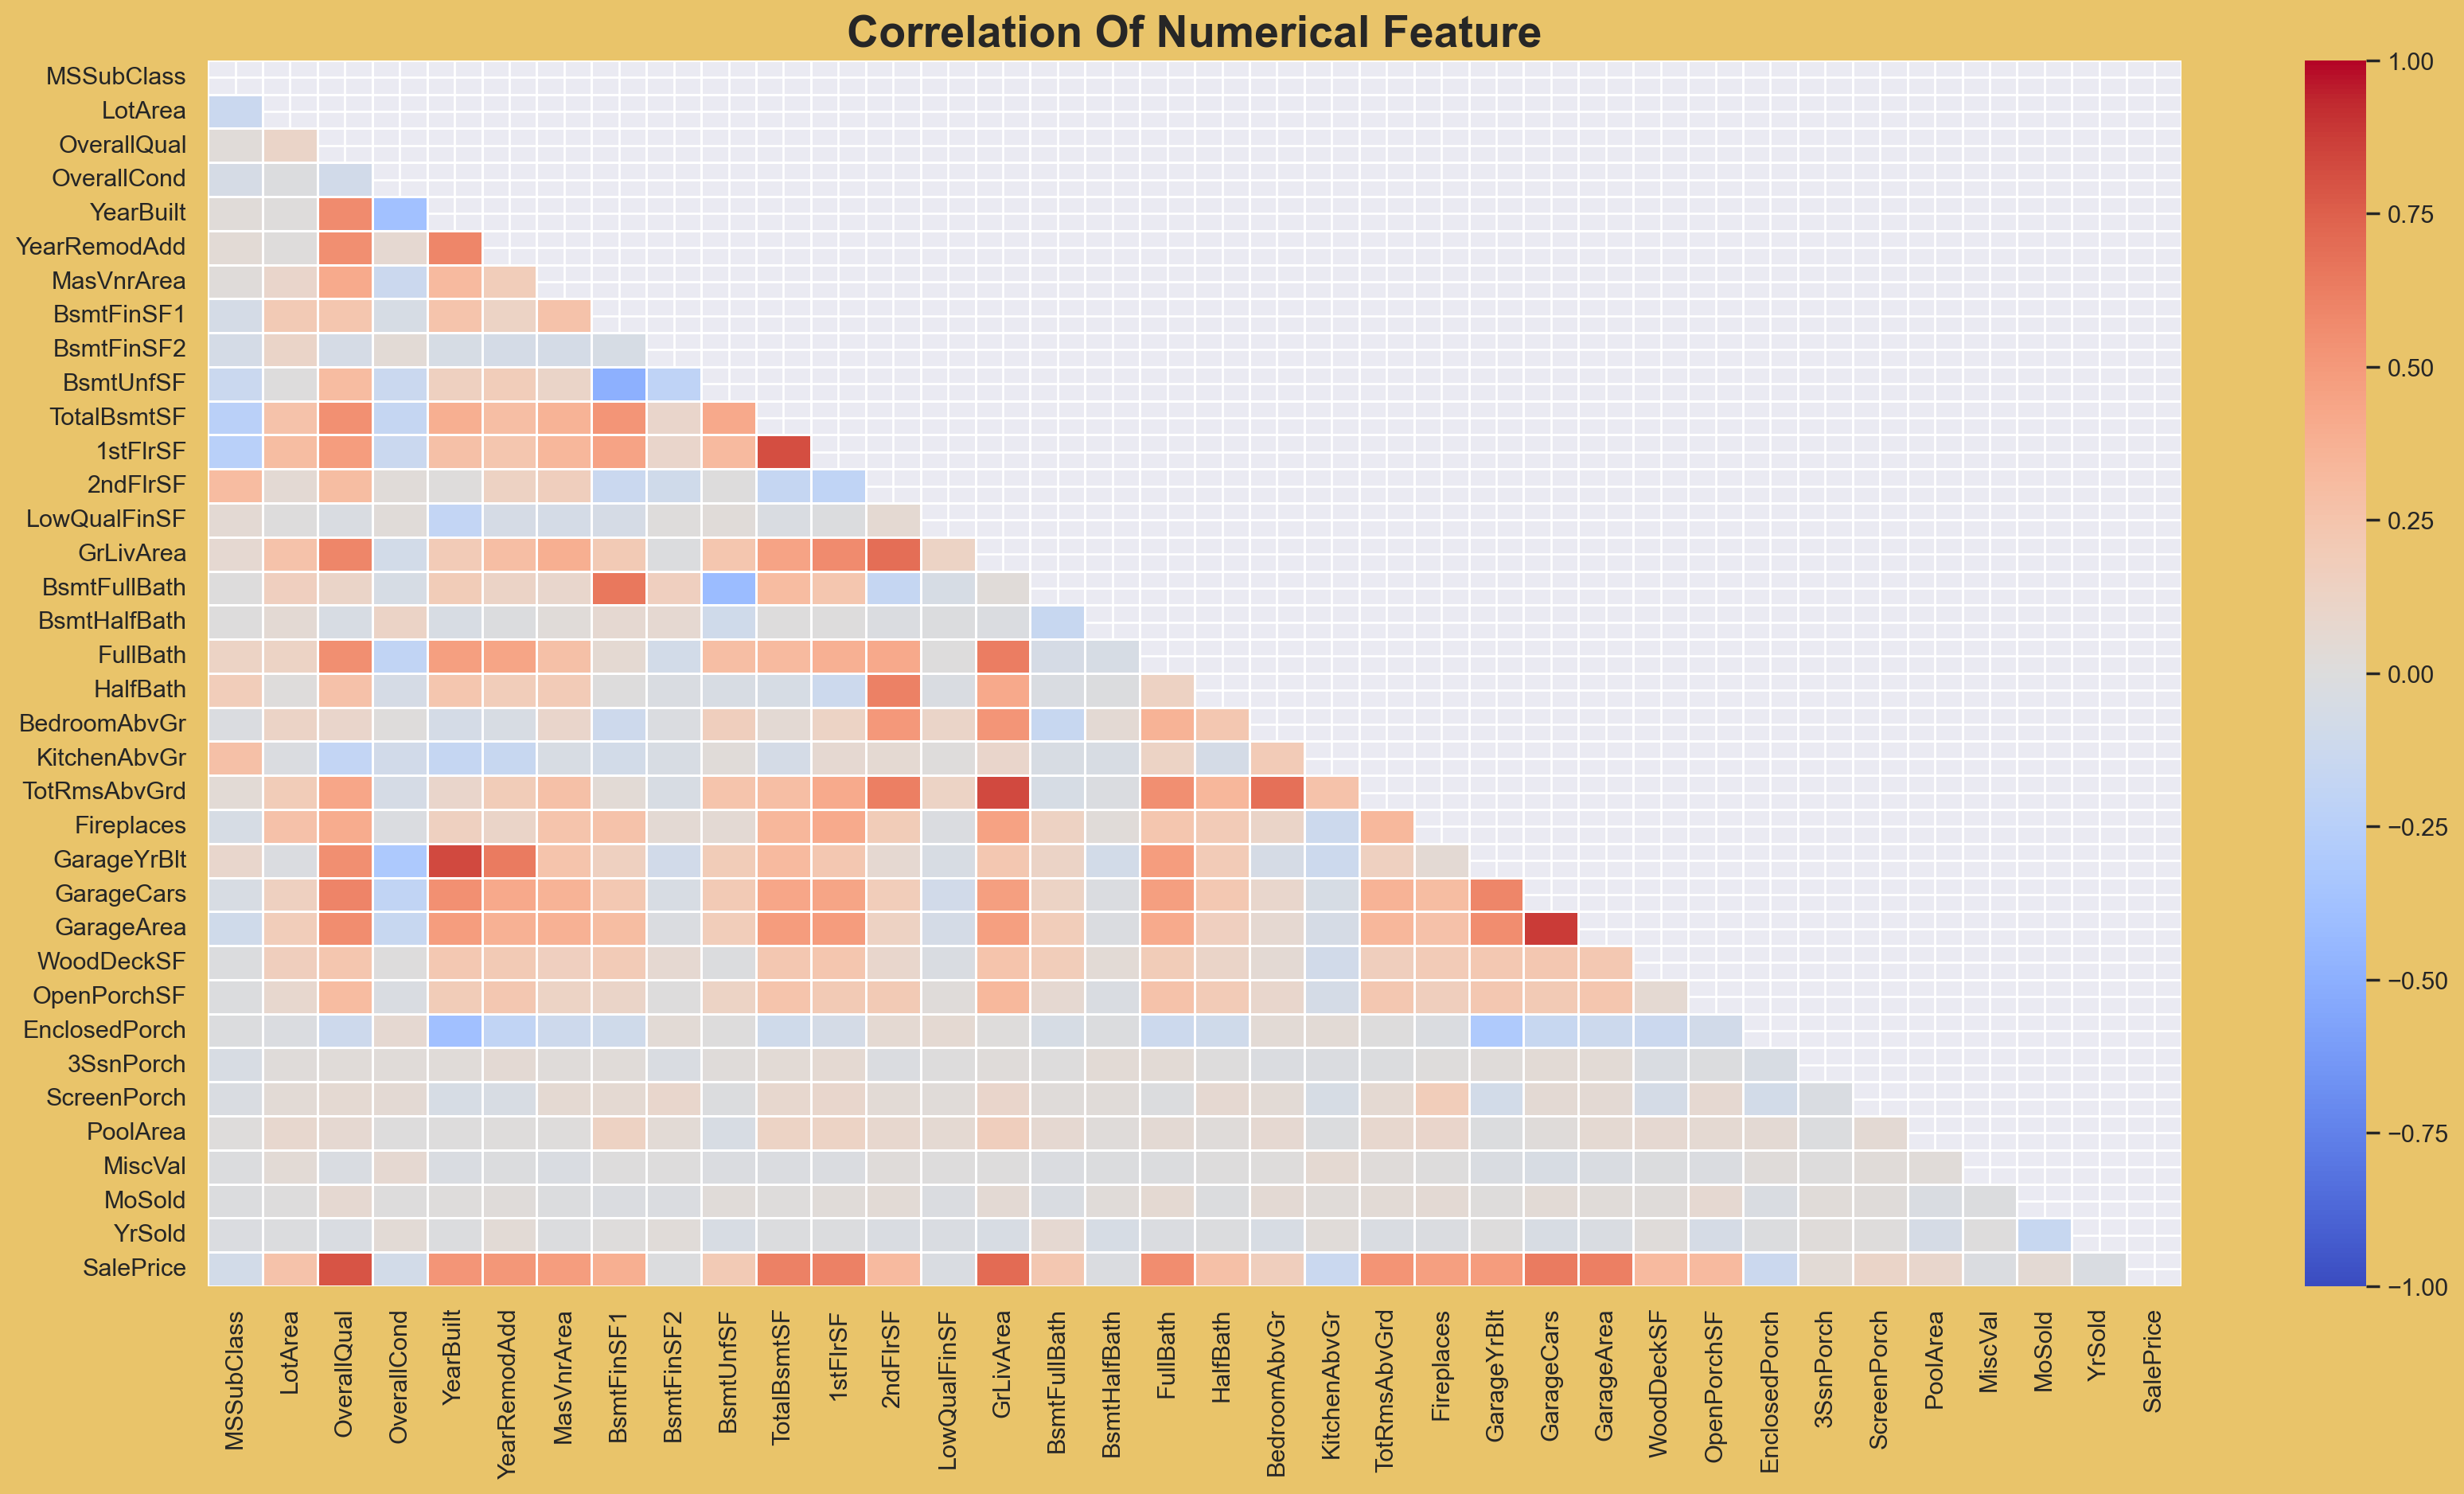

In [23]:
# Correlation
corrMatrix = numFeatures.corr().round(2)

plt.figure(figsize=(20, 10), dpi=200)
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

sns.heatmap(corrMatrix, annot=True, mask=mask, vmin=-1, vmax=1, annot_kws={'size':5}, linewidths=0.5, cmap='coolwarm');
plt.title('Correlation Of Numerical Feature', fontweight='bold', fontsize=20);

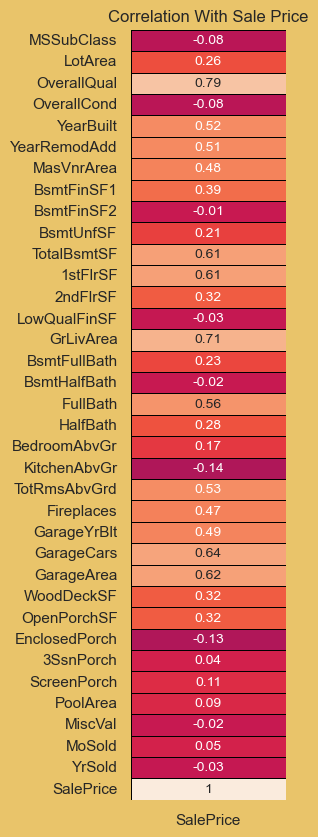

In [26]:
# Correlation between Numerical Features And Target Variable 'Sale Price'
targetCorr = corrMatrix['SalePrice'].to_frame()

plt.figure(figsize=(2, 10))
sns.heatmap(targetCorr, 
            annot=True, 
            annot_kws={'size':10}, 
            cbar=False, linewidths=0.5, 
            linecolor='black', 
            vmin=-1, 
            vmax=1)
plt.title('Correlation With Sale Price');

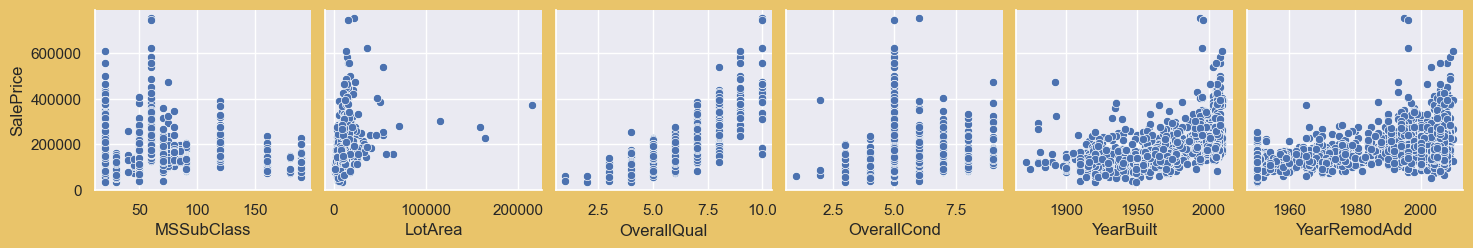

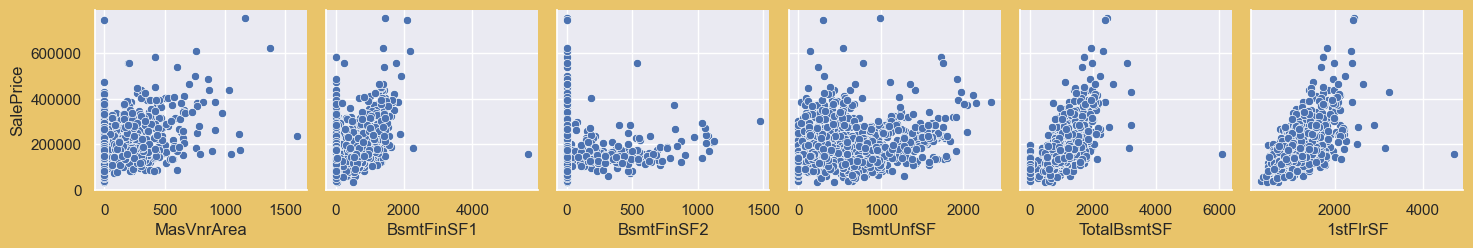

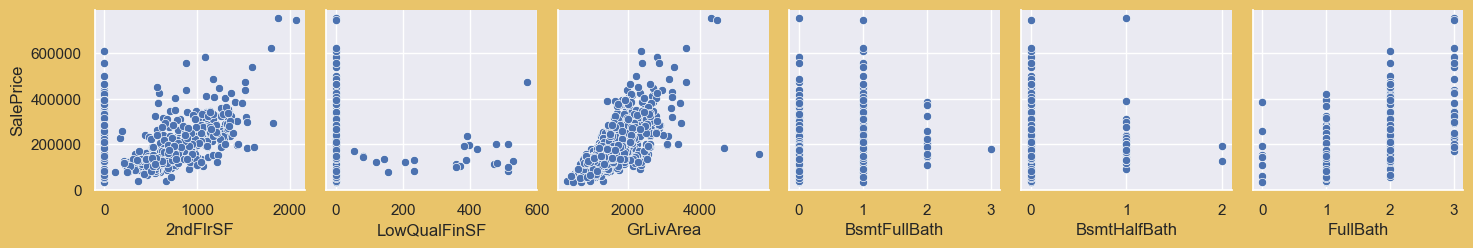

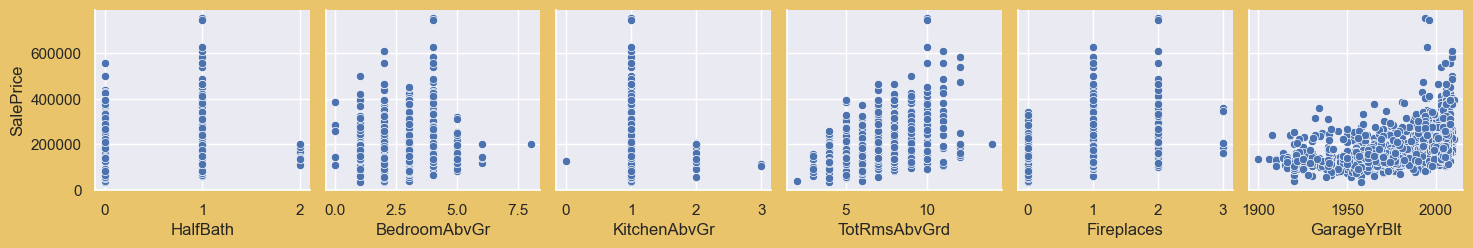

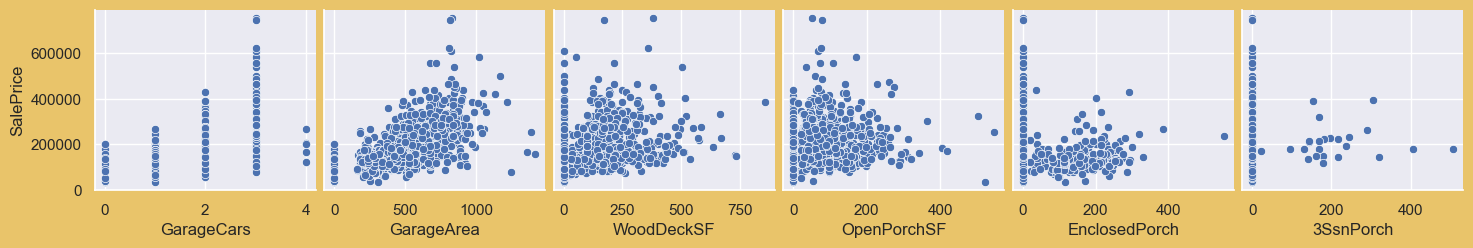

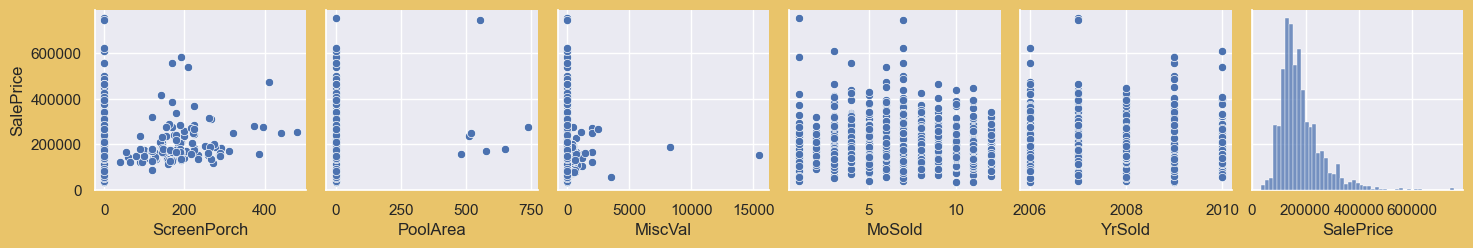

In [28]:
# Pairwise Relationships Between Numerical Features and Target Variable `SalePrice`
for i in range(0, len(numFeatures.columns), 6):
    sns.pairplot(data=numFeatures,
                x_vars=numFeatures.columns[i:i+6],
                y_vars=['SalePrice'])

In [30]:
# Categorical Features
catFeatures = df.select_dtypes(include=['object'])
catFeatures.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


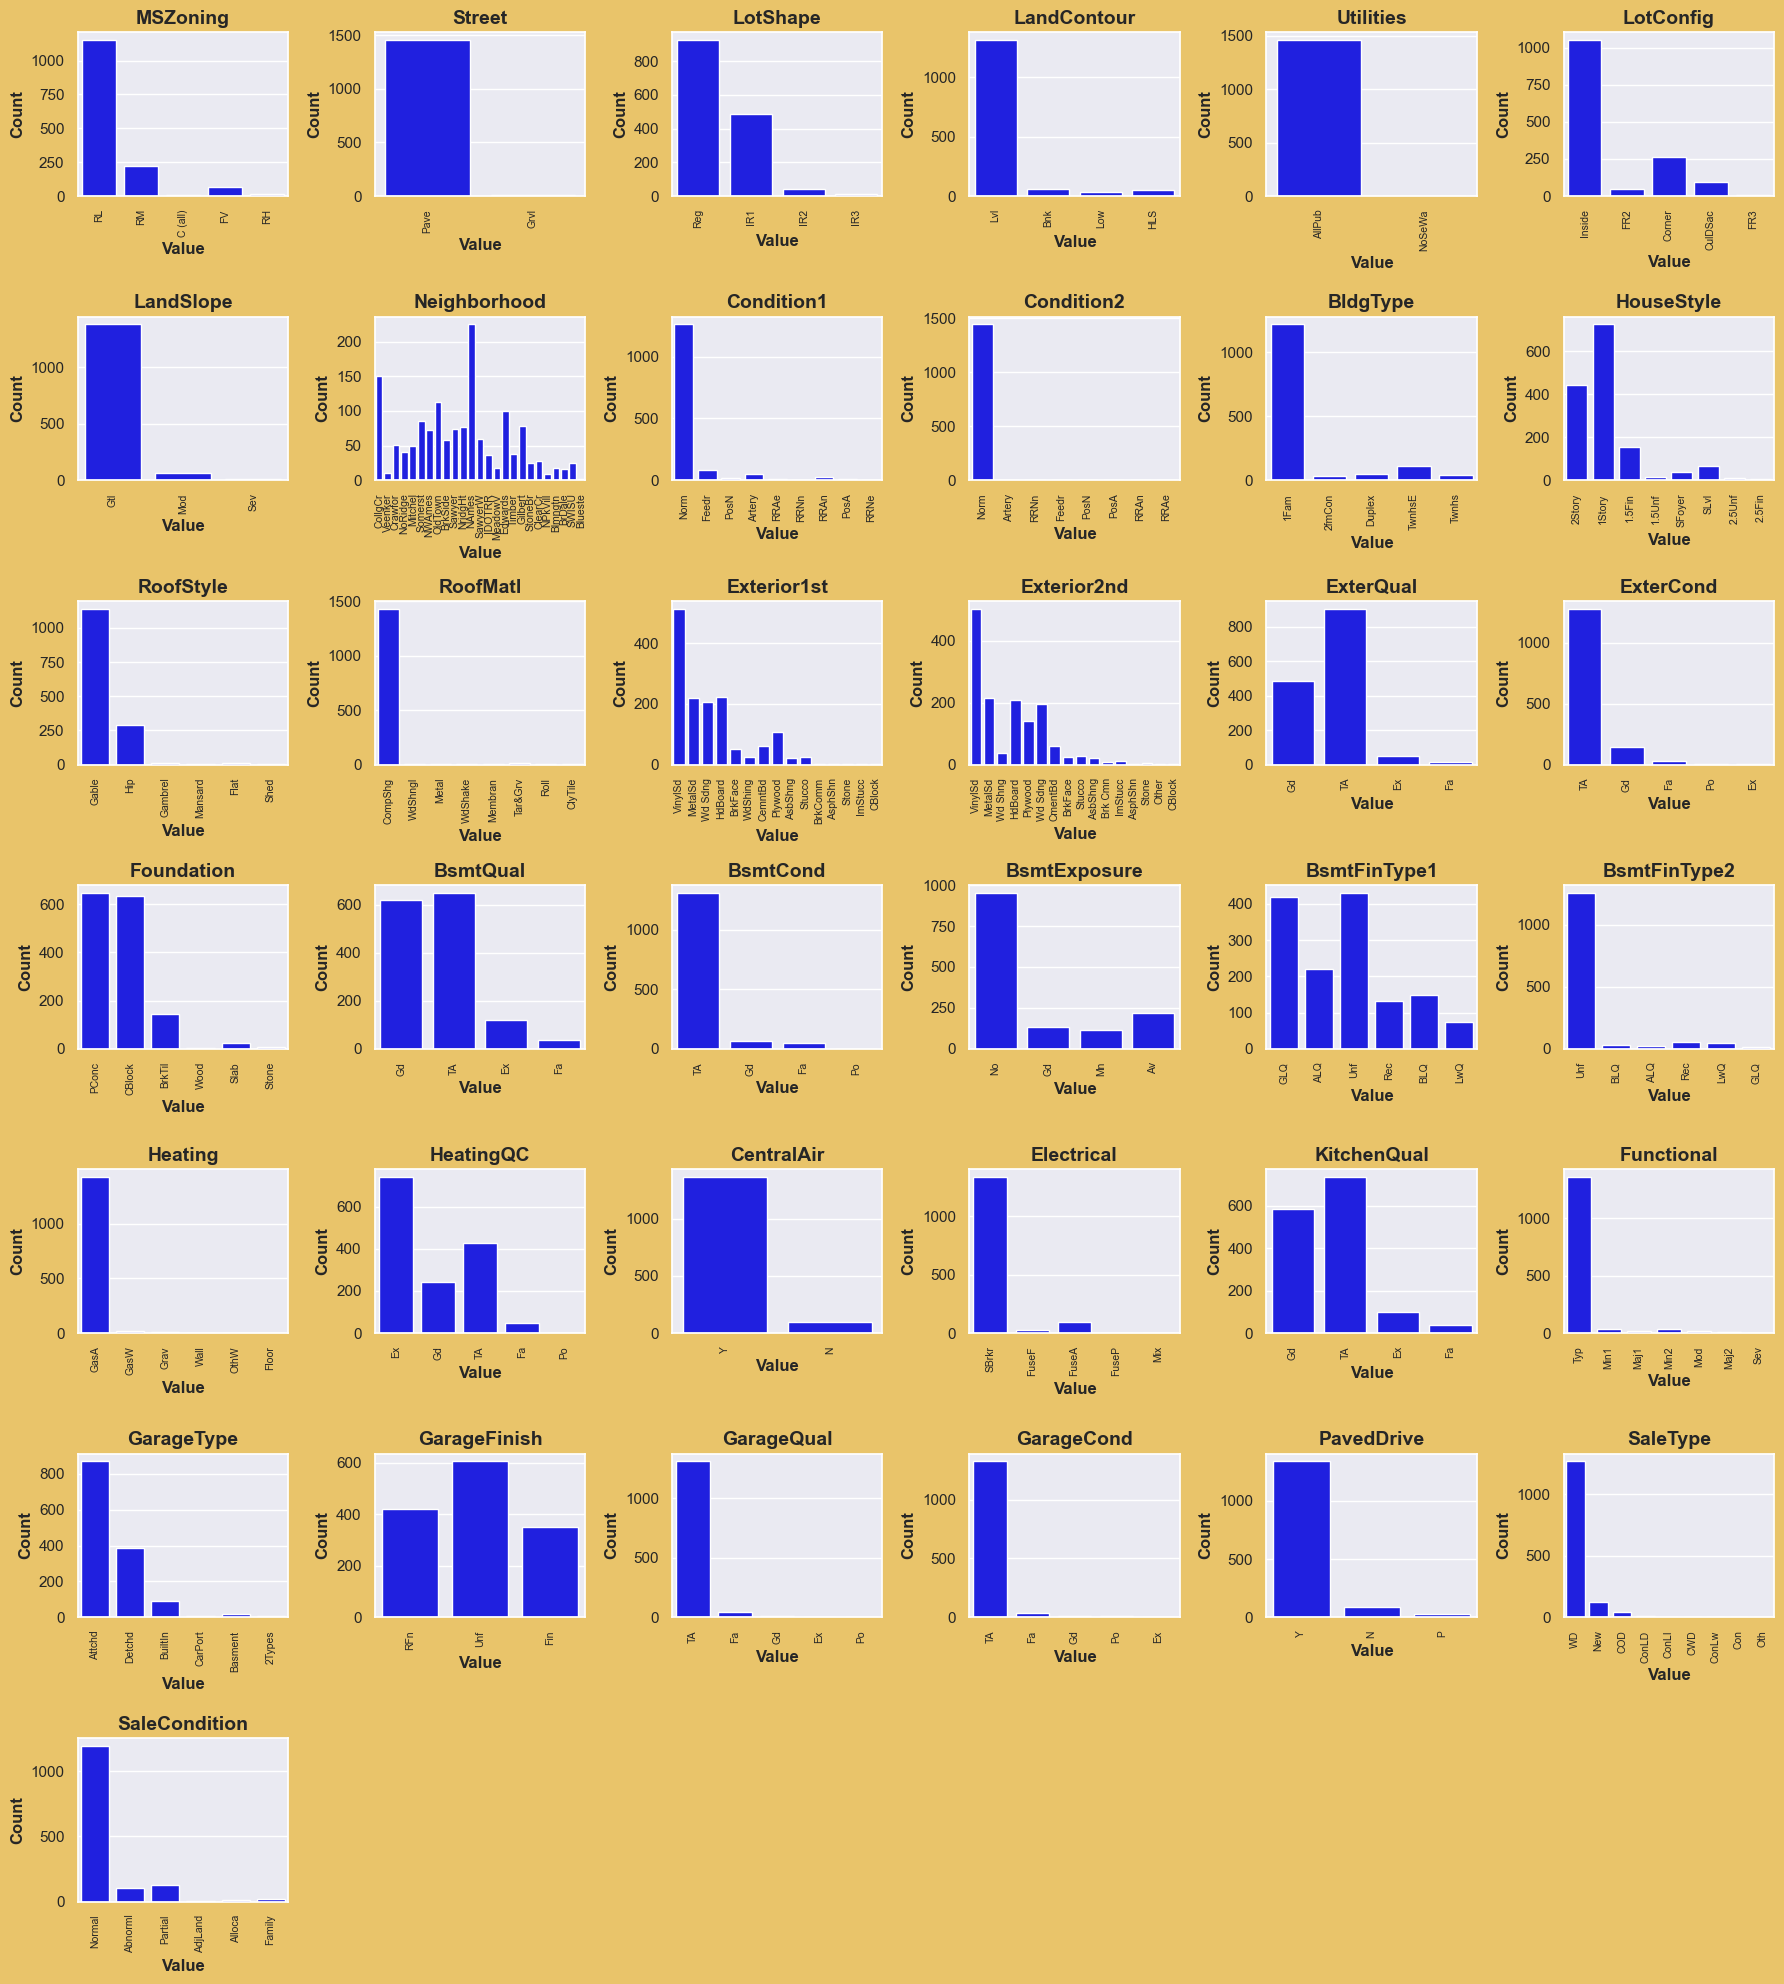

In [33]:
# Distribution Of Categorical Features
fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(18, 20))
axes = axes.flatten()

for index, col in enumerate(catFeatures.columns):
    sns.countplot(data=df, x=catFeatures[col], ax=axes[index], color='blue')
    axes[index].set_title(col, fontweight='bold', fontsize=14)
    axes[index].set_xlabel('Value', fontweight='bold')
    axes[index].set_ylabel('Count', fontweight='bold')
    axes[index].tick_params(axis='x', rotation=90, labelsize=7.5)

# Delete last five axes
for i in range(1, 6):
    fig.delaxes(axes[-i])

plt.tight_layout()
plt.show()

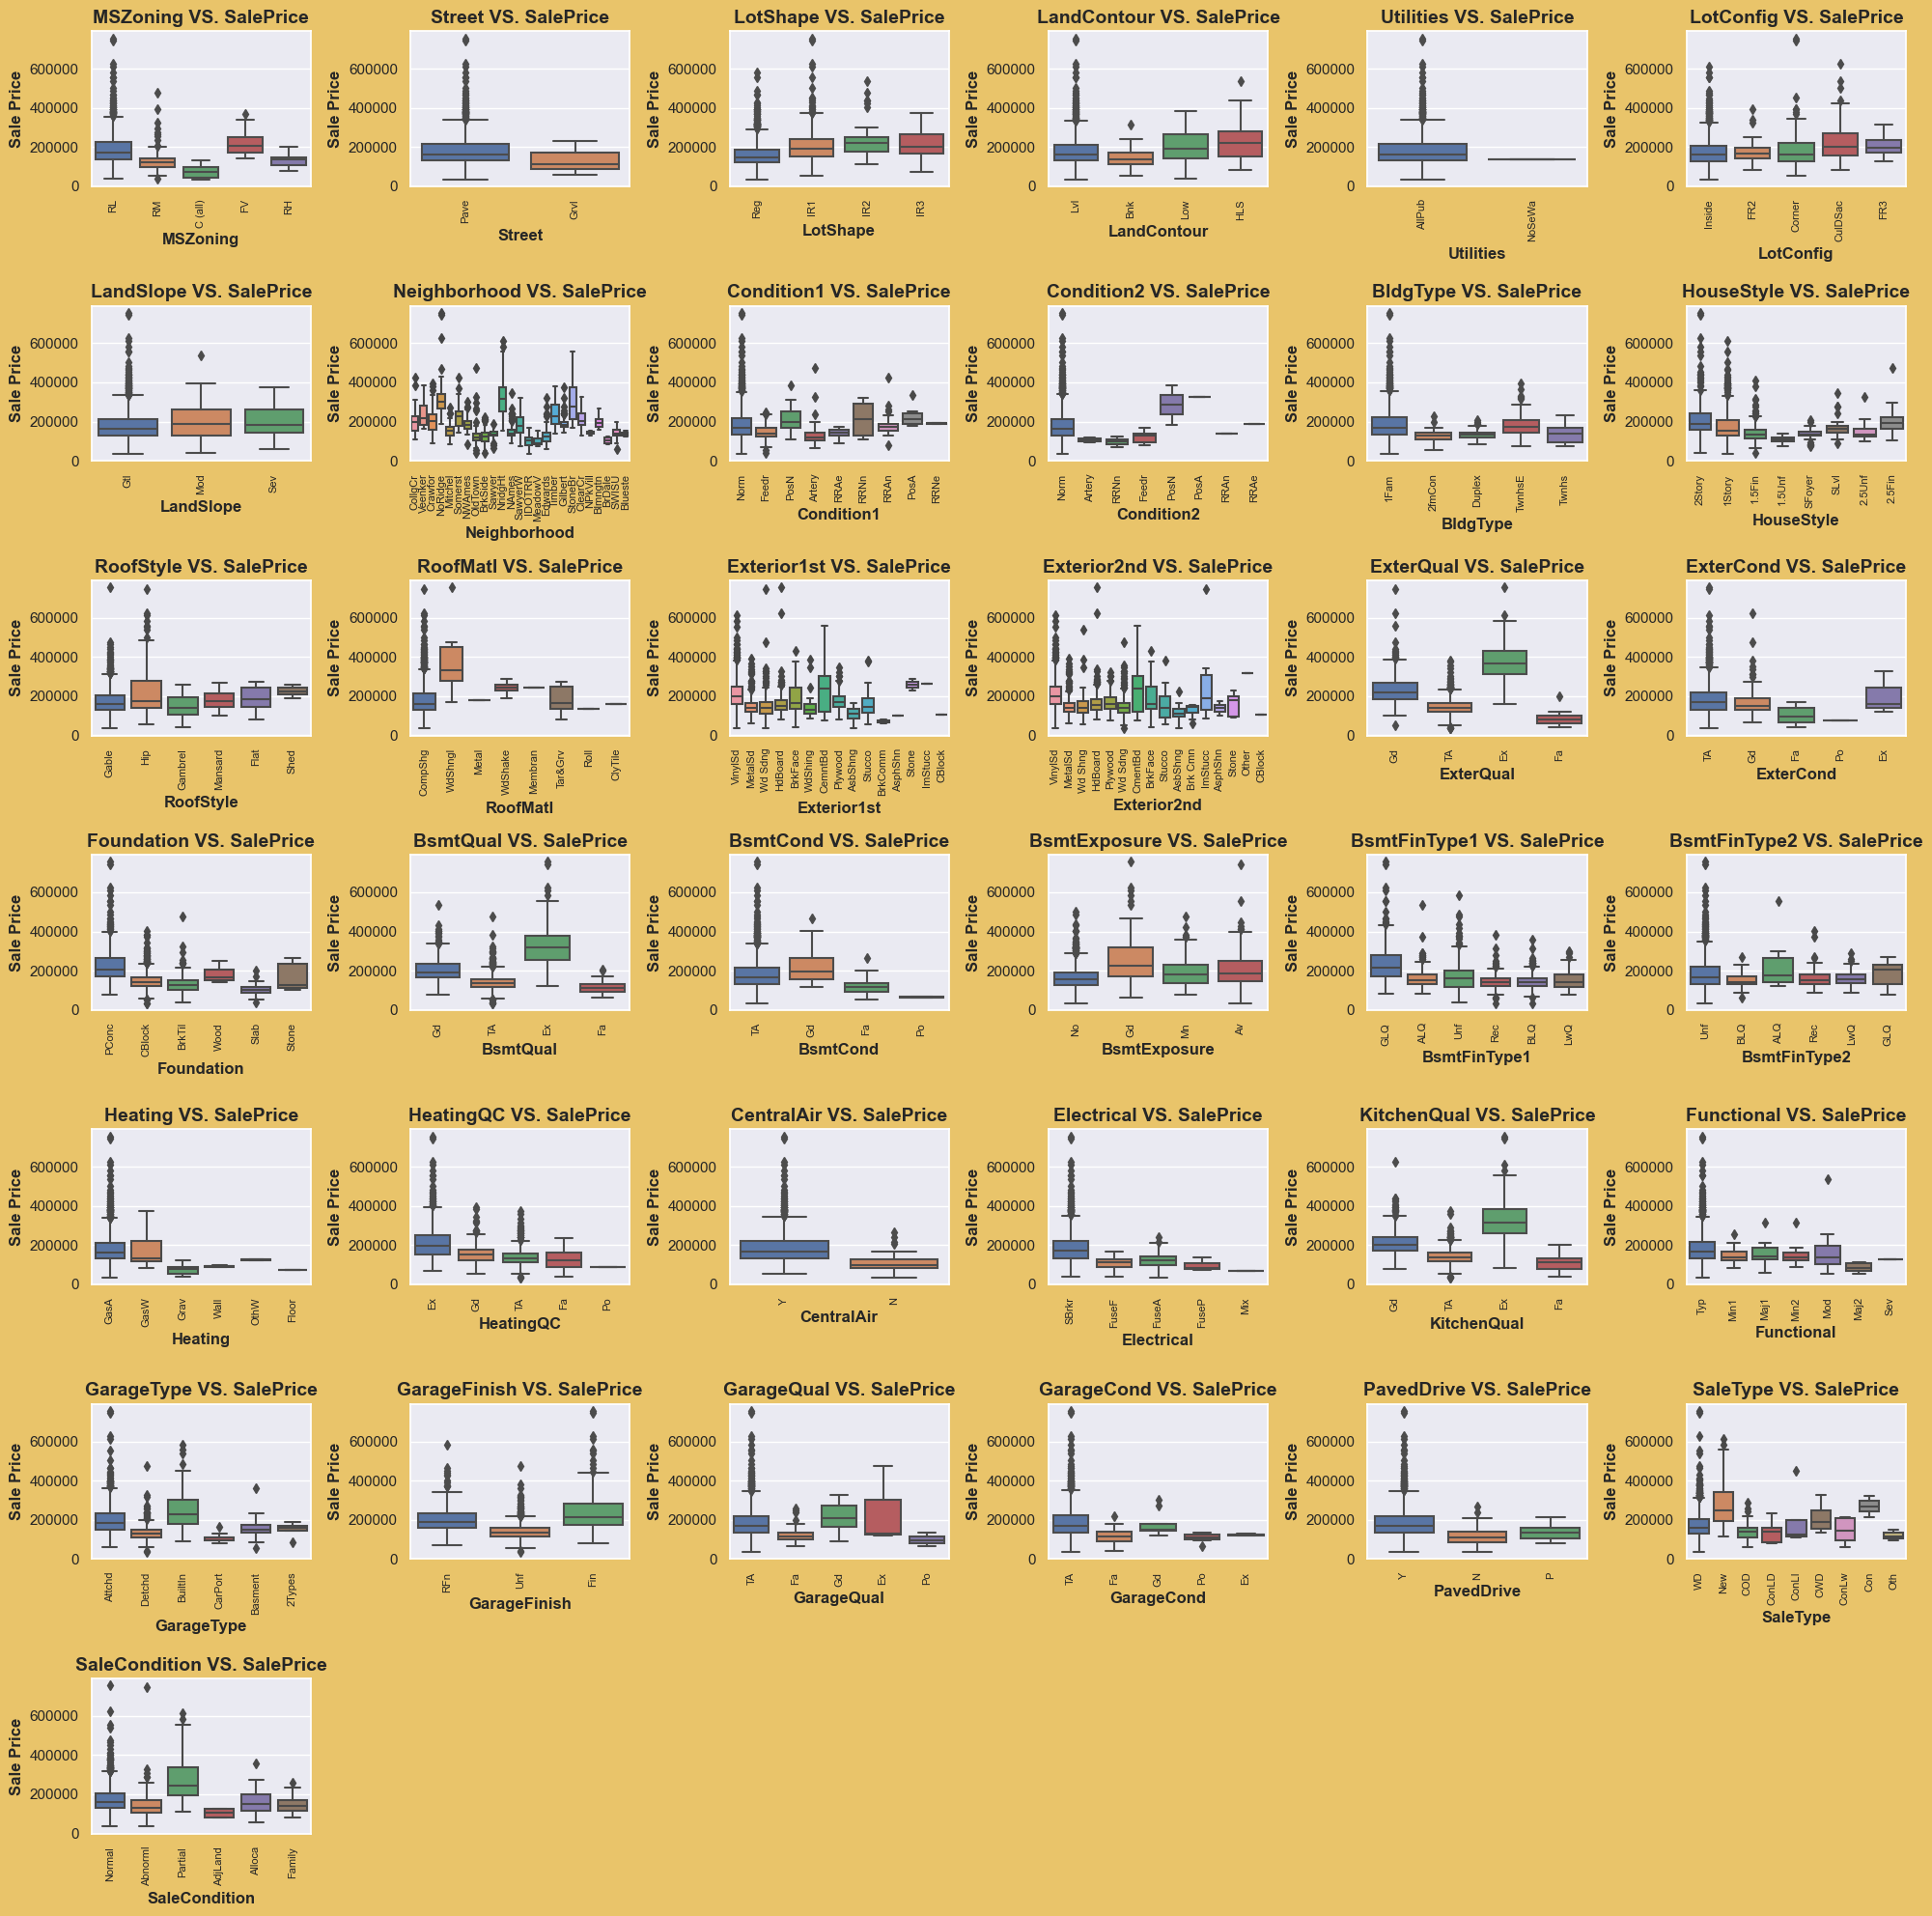

In [35]:
# Box Plots Of Categorical Features vs. Sale Price
fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(20, 20))
axes = axes.flatten()

for index, col in enumerate(catFeatures.columns):
    sns.boxplot(data=df, x=catFeatures[col], y="SalePrice", ax=axes[index])
    axes[index].set_title(f"{col} VS. SalePrice", fontweight="bold", fontsize=14)
    axes[index].set_xlabel(col, fontweight="bold")
    axes[index].set_ylabel("Sale Price", fontweight="bold")
    axes[index].tick_params(axis="x", rotation=90, labelsize=8)

# delete last 5 axes
for i in range(1, 6):
    fig.delaxes(axes[-i])

plt.tight_layout()

<a id="4"></a>

# <p style="text-align: left; background-color:#e9c46a; font-family:Comic Sans MS ; color:#1A4870; padding: 12px; line-height:1.5; border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 40px;border-style: solid;border-color: dark green; font-weight: bold;">Data Preprocessing</p>

In [38]:
# Splitting The Data Set Into Training Set And Testing Set
X = df.drop(columns="SalePrice")
y = df["SalePrice"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"The Shape Of X_train: {X_train.shape}")
print(f"The Shape Of y_train: {y_train.shape}")
print(f"The Shape Of X_valid: {X_valid.shape}")
print(f"The Shape Of y_valid: {y_valid.shape}")

The Shape Of X_train: (1168, 72)
The Shape Of y_train: (1168,)
The Shape Of X_valid: (292, 72)
The Shape Of y_valid: (292,)


In [41]:
# Creating a Pipeline For Preprocessing
# Numerical Columns
numCols = numFeatures.columns[:-1]
# Categorical Columns
catCols = catFeatures.columns

In [43]:
# Numerical Pipeline
numPipeline = Pipeline(steps=[
    ('Selector', DataFrameSelector(numCols)),
    ("Imputing", SimpleImputer(strategy="median")), 
    ("Scaling", StandardScaler())
])

# Categorical Pipeline
catPipeline = Pipeline(steps=[
    ("Selector", DataFrameSelector(catCols)), 
    ("Imputing", SimpleImputer(strategy='most_frequent')),
    ("Encoding", OneHotEncoder(sparse=False, handle_unknown="ignore", drop="first"))
])

# Total pipeline
totalPipeline = FeatureUnion(transformer_list=[
    ("NumericalPipeline", numPipeline),
    ("CategoricalPipeline", catPipeline)
])

In [45]:
X_train = totalPipeline.fit_transform(X_train)
X_valid = totalPipeline.transform(X_valid)

<a id="5"></a>

# <p style="text-align: left; background-color:#e9c46a; font-family:Comic Sans MS ; color:#1A4870; padding: 12px; line-height:1.5; border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 50px;border-style: solid;border-color: dark green; font-weight: bold;">Modeling And HyperParameters Tuning</p>

<center> <span style="font-family:Comic Sans MS"> <span style="padding:5px; display:fill; border-radius:20px 50px; background-color:#1A4870; font-size:200%; font-weight: 500; color:#e9c46a; overflow:hidden;">ㅤLassoㅤ</span> 

In [49]:
# Tuning And Fitting Lasso Parameters
params = {
    "alpha":np.arange(30, 40)
}

lasso = Lasso()
lassoCV = GridSearchCV(estimator=lasso, 
                        param_grid=params, 
                        cv=5,
                        verbose=2,
                        n_jobs=-1,
                        scoring="r2")

lassoCV.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])},
             scoring='r2', verbose=2)

In [50]:
print(f"Tuned Hyperparameter:(Best Parameters) {lassoCV.best_params_}")
print(f"Best Performance During The Tuning Process{lassoCV.best_score_}")

# Fitting The Best Lasso Parameters
bestLasso = lassoCV.best_estimator_
bestLasso.fit(X_train, y_train)

Tuned Hyperparameter:(Best Parameters) {'alpha': 39}
Best Performance During The Tuning Process0.7758075666398093


Lasso(alpha=39)

In [53]:
# Calculate traing score And RMSE
y_train_pred = bestLasso.predict(X_train)
trainScore = r2_score(y_train, y_train_pred)
trainRMSE = mean_squared_error(y_train, y_train_pred) ** 0.5

# Calculating Validaion Accuracy
y_valid_pred = bestLasso.predict(X_valid)
validScore = r2_score(y_valid, y_valid_pred)
validRMSE = mean_squared_error(y_valid, y_valid_pred) ** 0.5

print(f"Training Score: {trainScore}")
print(f"Validation Score: {validScore}")
print(f"Training RMSE : {trainRMSE}")
print(f"Validation RMSE : {validRMSE}")

Training Score: 0.9035560258716084
Validation Score: 0.8860706954079466
Training RMSE : 23984.264477237448
Validation RMSE : 29561.375657757057


In [55]:
# Feature Selection Using `Lasso`
coef = bestLasso.coef_ 
selectedFeatures = np.where(coef != 0)[0]

X_train_sel = X_train[:, selectedFeatures]
X_valid_sel = X_valid[:, selectedFeatures]

<center> <span style="font-family:Comic Sans MS"> <span style="padding:5px; display:fill; border-radius:20px 50px; background-color:#1A4870; font-size:200%; font-weight: 500; color:#e9c46a; overflow:hidden;">ㅤLinear Regressionㅤ</span> 

In [57]:
# Fitting Linear Regression On Selected Features
LinReg = LinearRegression()
LinReg.fit(X_train_sel, y_train)

LinearRegression()

In [59]:
# Calculate traing score And RMSE
y_train_pred = LinReg.predict(X_train_sel)
trainScore = r2_score(y_train, y_train_pred)
trainRMSE = mean_squared_error(y_train, y_train_pred) ** 0.5

# Calculating Validaion Accuracy
y_valid_pred = LinReg.predict(X_valid_sel)
validScore = r2_score(y_valid, y_valid_pred)
validRMSE = mean_squared_error(y_valid, y_valid_pred) ** 0.5

print(f"Training Score: {trainScore}")
print(f"Validation Score: {validScore}")
print(f"Training RMSE : {trainRMSE}")
print(f"Validation RMSE : {validRMSE}")

Training Score: 0.9274979658698757
Validation Score: 0.7161669455650753
Training RMSE : 20795.24068639184
Validation RMSE : 46659.31971105208


<center> <span style="font-family:Comic Sans MS"> <span style="padding:5px; display:fill; border-radius:20px 50px; background-color:#1A4870; font-size:200%; font-weight: 500; color:#e9c46a; overflow:hidden;">ㅤRidgeㅤ</span> 

In [62]:
# Fitting Ridge On Selected Features
ridge_reg = Ridge()
ridge_reg.fit(X_train_sel, y_train)

Ridge()

In [64]:
# Calculate traing score And RMSE
y_train_pred = ridge_reg.predict(X_train_sel)
trainScore = r2_score(y_train, y_train_pred)
trainRMSE = mean_squared_error(y_train, y_train_pred) ** 0.5

# Calculating Validaion Accuracy
y_valid_pred = ridge_reg.predict(X_valid_sel)
validScore = r2_score(y_valid, y_valid_pred)
validRMSE = mean_squared_error(y_valid, y_valid_pred) ** 0.5

print(f"Training Score: {trainScore}")
print(f"Validation Score: {validScore}")
print(f"Training RMSE : {trainRMSE}")
print(f"Validation RMSE : {validRMSE}")

Training Score: 0.9043452067978804
Validation Score: 0.8829782175990116
Training RMSE : 23885.933792099702
Validation RMSE : 29959.89393108811


<center> <span style="font-family:Comic Sans MS"> <span style="padding:5px; display:fill; border-radius:20px 50px; background-color:#1A4870; font-size:200%; font-weight: 500; color:#e9c46a; overflow:hidden;">ㅤStochastic Gradient Descentㅤ</span> 

In [67]:
# Fitting Stochastic Gradient Descent On Selected Features
sgd = SGDRegressor(alpha=0.00001, 
                    random_state=42)
sgd.fit(X_train_sel, y_train)

SGDRegressor(alpha=1e-05, random_state=42)

In [69]:
# Calculate traing score And RMSE
y_train_pred = sgd.predict(X_train_sel)
trainScore = r2_score(y_train, y_train_pred)
trainRMSE = mean_squared_error(y_train, y_train_pred) ** 0.5

# Calculating Validaion Accuracy
y_valid_pred = sgd.predict(X_valid_sel)
validScore = r2_score(y_valid, y_valid_pred)
validRMSE = mean_squared_error(y_valid, y_valid_pred) ** 0.5

print(f"Training Score: {trainScore}")
print(f"Validation Score: {validScore}")
print(f"Training RMSE : {trainRMSE}")
print(f"Validation RMSE : {validRMSE}")

Training Score: 0.880017544904474
Validation Score: 0.8712258342450607
Training RMSE : 26751.47469030102
Validation RMSE : 31428.328915148657


<center> <span style="font-family:Comic Sans MS"> <span style="padding:5px; display:fill; border-radius:20px 50px; background-color:#1A4870; font-size:200%; font-weight: 500; color:#e9c46a; overflow:hidden;">ㅤRandom Forest Regressionㅤ</span> 

In [72]:
# Fitting Random Forest On Selected Features
forest = RandomForestRegressor()
forest.fit(X_train_sel, y_train)

RandomForestRegressor()

In [73]:
# Calculate traing score And RMSE
y_train_pred = forest.predict(X_train_sel)
trainScore = r2_score(y_train, y_train_pred)
trainRMSE = mean_squared_error(y_train, y_train_pred) ** 0.5

# Calculating Validaion Accuracy
y_valid_pred = forest.predict(X_valid_sel)
validScore = r2_score(y_valid, y_valid_pred)
validRMSE = mean_squared_error(y_valid, y_valid_pred) ** 0.5

print(f"Training Score: {trainScore}")
print(f"Validation Score: {validScore}")
print(f"Training RMSE : {trainRMSE}")
print(f"Validation RMSE : {validRMSE}")

Training Score: 0.9801445698879309
Validation Score: 0.8973283026802822
Training RMSE : 10882.495725496448
Validation RMSE : 28062.883149951213


<center> <span style="font-family:Comic Sans MS"> <span style="padding:5px; display:fill; border-radius:20px 50px; background-color:#1A4870; font-size:200%; font-weight: 500; color:#e9c46a; overflow:hidden;">ㅤXGBoost Regressionㅤ</span> 

In [77]:
params = {
    'alpha': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [ 3, 4, 5, 7],
}
# Fitting XGBoost On Selected Features
xgboost_reg = XGBRegressor()
xgbCV = GridSearchCV(estimator=xgboost_reg, 
                        param_grid=params, 
                        cv=5, 
                        scoring="r2", 
                        verbose=2, 
                        n_jobs=-1)
xgbCV.fit(X_train_sel, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 7]},
             scoring='r2', verbose=2)

In [78]:
print(f"Tuned Hyperparameter:(Best Parameters) {xgbCV.best_params_}")
print(f"Best Performance During The Tuning Process{xgbCV.best_score_}")

# Fitting The Best Lasso Parameters
bestXGB = xgbCV.best_estimator_
bestXGB.fit(X_train_sel, y_train)

Tuned Hyperparameter:(Best Parameters) {'alpha': 0.1, 'max_depth': 3}
Best Performance During The Tuning Process0.8653571039903756


XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, ...)

In [81]:
# Calculate traing score And RMSE
y_train_pred = bestXGB.predict(X_train_sel)
trainScore = r2_score(y_train, y_train_pred)
trainRMSE = mean_squared_error(y_train, y_train_pred) ** 0.5

# Calculating Validaion Accuracy And RMSE
y_valid_pred = bestXGB.predict(X_valid_sel)
validScore = r2_score(y_valid, y_valid_pred)
validRMSE = mean_squared_error(y_valid, y_valid_pred) ** 0.5

print(f"Training Score: {trainScore}")
print(f"Validation Score: {validScore}")
print(f"Training RMSE : {trainRMSE}")
print(f"Validation RMSE : {validRMSE}")

Training Score: 0.9828783085880677
Validation Score: 0.921256706350441
Training RMSE : 10105.60196194934
Validation RMSE : 24576.141864020155


<center> <span style="font-family:Comic Sans MS"> <span style="padding:5px; display:fill; border-radius:20px 50px; background-color:#1A4870; font-size:200%; font-weight: 500; color:#e9c46a; overflow:hidden;">ㅤSaving The Best Modelㅤ</span> 

In [84]:
joblib.dump(bestXGB, "Models/BestModel.pkl")

['Models/BestModel.pkl']

<a id="6"></a>

# <p style="text-align: left; background-color:#e9c46a; font-family:Comic Sans MS ; color:#1A4870; padding: 12px; line-height:1.5; border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 50px;border-style: solid;border-color: dark green; font-weight: bold;">Evaluation On Test Data</p>

In [87]:
X_test_Df = pd.read_csv(r"Data\test.csv")
X_test_Df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [89]:
print(f"Number Of Rows In The Testing Set: {X_test_Df.shape[0]}")
print(f"Number Of Columns In The Testing Set: {X_test_Df.shape[1]}")

Number Of Rows In The Testing Set: 1459
Number Of Columns In The Testing Set: 80


In [91]:
# Missing Values Ratio
missingRat = X_test_Df.isnull().sum() / X_test_Df.shape[0]
# drop columns with nulls > 10%
X_testDf = X_test_Df.drop(columns=missingRat[missingRat > 0.10].index)
# drop id column
# testDf = test_Df.drop(columns='Id')

In [93]:
X_test = totalPipeline.transform(X_testDf)

In [95]:
X_test_sel = X_test[:, selectedFeatures]

In [97]:
loadedModel = joblib.load("Models/BestModel.pkl")

In [99]:
y = loadedModel.predict(X_test_sel)

<a id="7"></a>

# <p style="text-align: left; background-color:#e9c46a; font-family:Comic Sans MS ; color:#1A4870; padding: 12px; line-height:1.5; border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 50px;border-style: solid;border-color: dark green; font-weight: bold;">Submission</p>

In [104]:
sub = {
    "Id": X_test_Df["Id"],
    "y": y
}

SubmissionDf = pd.DataFrame(sub)
SubmissionDf.to_csv("Data/Submission.csv")